In [1]:
from google.colab import files
import io
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import scipy.stats as stats
from matplotlib.lines import Line2D
from matplotlib import ticker
import matplotlib.gridspec as gridspec

In [2]:
# Mounting my google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##1) Empirical divergence correlation and its 95% confidence interval

In [3]:
# Function to compute the confidence interval on spearman rho
def spearman_ci(x, y, ci=95, n_boots=10000, seed=22):
  x = np.asarray(x)
  y = np.asarray(y)

  # (n_boots, n_observations) paired arrays
  rng = np.random.default_rng(seed) # For reproducible bootstrapping
  rand_ixs = rng.integers(0, x.shape[0], size=(n_boots, x.shape[0]))
  x_boots = x[rand_ixs]
  y_boots = y[rand_ixs]

  # Spearman correlations
  corrs = []

  for row in range(x_boots.shape[0]):
    rho = stats.spearmanr(x_boots[row, :], y_boots[row, :])
    corrs.append(rho[0])

  # Quantiles of correlations coefficients and confidence interval
  corrs = np.asarray(corrs)

  ci_low = np.percentile(corrs, (100 - ci) / 2)
  ci_high = np.percentile(corrs, (ci + 100) / 2)

  return ci_low, ci_high, corrs

In [4]:
# Empirical divergence data is imported
couples_divergence = pd.read_csv('/content/drive/My Drive/Redaction_SA/'
                                 'Final_figures/Data_sim_ready/'
                                 'couples_divergence.csv')

# Only WGD-derived pairs are kept
couples_divergence = couples_divergence[couples_divergence['Duplication'] == 'WGD'].reset_index(drop=True)

In [5]:
# Confidence interval on the empirical correlation of divergence
rho_emp = spearman_ci(couples_divergence['bm_fold_original'],
                      couples_divergence['bp_fold_original'])
spearman_ci_div = (rho_emp[0], rho_emp[1])
dist_boot_div = rho_emp[2]

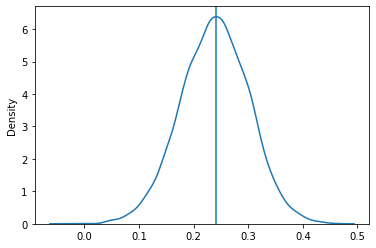

In [6]:
# Quick validation that bootstrapping is valid:
center_div = stats.spearmanr(couples_divergence['bm_fold_original'],
                         couples_divergence['bp_fold_original'])[0]

sns.kdeplot(dist_boot_div)
plt.axvline(x=center_div)

The 95% confidence interval is also computed for the signed divergence correlation:

In this case, a duplicated dataset is used, so that logfold changes are computed in the two possible orientations for each paralog pair

In [7]:
couples_divergence['bm_fold_signed_1'] = np.log2((10**couples_divergence['bm_P1']) / (10**couples_divergence['bm_P2']))
couples_divergence['bp_fold_signed_1'] = np.log2((10**couples_divergence['bp_P1']) / (10**couples_divergence['bp_P2']))
couples_divergence['bm_fold_signed_2'] = np.log2((10**couples_divergence['bm_P2']) / (10**couples_divergence['bm_P1']))
couples_divergence['bp_fold_signed_2'] = np.log2((10**couples_divergence['bp_P2']) / (10**couples_divergence['bp_P1']))

In [8]:
logfold_dupli_1 = couples_divergence[['Duplication', 'ORF_P1', 'ORF_P2',
                                    'bm_fold_signed_1', 'bp_fold_signed_1']].copy()

logfold_dupli_1.columns = ['Duplication', 'ORF_P1', 'ORF_P2',
                          'bm_fold_signed', 'bp_fold_signed']


logfold_dupli_2 = couples_divergence[['Duplication', 'ORF_P1', 'ORF_P2',
                                    'bm_fold_signed_2', 'bp_fold_signed_2']].copy()

logfold_dupli_2.columns = ['Duplication', 'ORF_P1', 'ORF_P2',
                          'bm_fold_signed', 'bp_fold_signed']

logfold_dupli = pd.concat([logfold_dupli_1, logfold_dupli_2])

In [9]:
# Confidence interval on the empirical correlation of divergence
rho_emp = spearman_ci(logfold_dupli['bm_fold_signed'],
                      logfold_dupli['bp_fold_signed'])
spearman_ci_sign = (rho_emp[0], rho_emp[1])
dist_boot_sign = rho_emp[2]

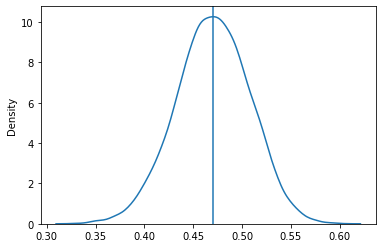

In [10]:
# Quick validation that bootstrapping is valid:
center_sign = stats.spearmanr(logfold_dupli['bm_fold_signed'],
                              logfold_dupli['bp_fold_signed'])[0]

sns.kdeplot(dist_boot_sign)
plt.axvline(x=center_sign)

Finally, the same is done for the correlation between the divergence ratio and the magnitude of protein abundance divergence:

In [11]:
couples_divergence['div_ratio'] = couples_divergence['bm_fold_original'] - couples_divergence['bp_fold_original']

In [12]:
# Confidence interval on the empirical correlation of divergence
rho_emp = spearman_ci(couples_divergence['pEst_fold_original'],
                      couples_divergence['div_ratio'])
spearman_ci_ratio = (rho_emp[0], rho_emp[1])
dist_boot_ratio = rho_emp[2]

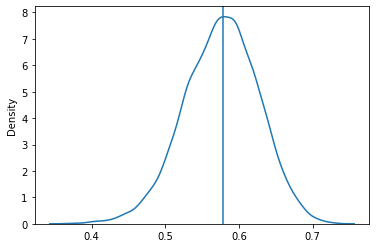

In [13]:
# Quick validation that bootstrapping is valid:
center_ratio = stats.spearmanr(couples_divergence['pEst_fold_original'],
                         couples_divergence['div_ratio'])[0]

sns.kdeplot(dist_boot_ratio)
plt.axvline(x=center_ratio)

##2) Preparation of simulation data

Calculation of the simulated correlations across the spectrum of mutational target size ratios for all models for the best run (SD=0.025):

In [14]:
# As the melted dataframe exported at the end of the simulation do not preserve
# the associations between Bm and Bp log2 fold-changes, they have to be
# recalculated from the final transcription and translation rates

os.chdir('/content/drive/My Drive/Redaction_SA/Final_figures/'
         'Mut_SD_WGD')

# Same for the mixed data
data_mixed = pd.DataFrame(columns=['Round', 'Couple', 'Bm1', 'Bp1', 'Bm2', 
                                   'Bp2', 'Prot1', 'Prot2', 'Run'])
files_mixed = glob.glob('data_Mixed*.csv')

for name in files_mixed:
    df = pd.read_csv(name)
    df['Run'] = name[11:-4]

    df = df[df['Round'] != 0]
    df = df.drop(labels=['cv1', 'cv2', 'Exp_cost'], axis=1)

    data_mixed = pd.concat([data_mixed, df])

data_mixed['Model'] = 'Mixed'
data_mixed = data_mixed.reset_index(drop=True)

# Same for minimal data
data_minimal = pd.DataFrame(columns=['Round', 'Couple', 'Bm1', 'Bp1', 'Bm2', 
                                     'Bp2', 'Prot1', 'Prot2', 'Run'])
files_minimal = glob.glob('data_minimal*.csv')

for name in files_minimal:
    df = pd.read_csv(name)
    df['Run'] = name[13:-4]

    df = df[df['Round'] != 0]
    df = df.drop(labels=['cv1', 'cv2', 'Exp_cost'], axis=1)

    data_minimal = pd.concat([data_minimal, df])

data_minimal['Model'] = 'Minimal'
data_minimal = data_minimal.reset_index(drop=True)

In [15]:
# The data are concatenated, and all transcriptional and translational 
# log2 fold-changes are calculated in the same direction 
# (most expressed / least expressed), according to final protein abundance

data_all = pd.concat([data_mixed, data_minimal])
data_all = data_all.reset_index(drop=True)

P1_higher = np.where(data_all['Prot1'] >= data_all['Prot2'], 1, 0)
P2_higher = np.where(data_all['Prot1'] < data_all['Prot2'], 1, 0)

Bm1_higher = np.where(data_all['Bm1'] >= data_all['Bm2'], 1, 0)
Bm2_higher = np.where(data_all['Bm1'] < data_all['Bm2'], 1, 0)
Bp1_higher = np.where(data_all['Bp1'] >= data_all['Bp2'], 1, 0)
Bp2_higher = np.where(data_all['Bp1'] < data_all['Bp2'], 1, 0)

data_P1 = data_all.copy()
data_P2 = data_all.copy()

data_P1['Logfold_Bm'] = data_P1['Bm1'] / data_P1['Bm2']
data_P1['Logfold_Bp'] = data_P1['Bp1'] / data_P1['Bp2']
data_P1['Logfold_pEst'] = data_P1['Prot1'] / data_P1['Prot2']

data_P2['Logfold_Bm'] = data_P2['Bm2'] / data_P2['Bm1']
data_P2['Logfold_Bp'] = data_P2['Bp2'] / data_P2['Bp1']
data_P2['Logfold_pEst'] = data_P2['Prot2'] / data_P2['Prot1']

data_P1.iloc[:, 10] = data_P1.iloc[:, 10] * Bm1_higher
data_P1.iloc[:, 11] = data_P1.iloc[:, 11] * Bp1_higher
data_P1.iloc[:, 12] = data_P1.iloc[:, 12] * P1_higher

data_P2.iloc[:, 10] = data_P2.iloc[:, 10] * Bm2_higher
data_P2.iloc[:, 11] = data_P2.iloc[:, 11] * Bp2_higher
data_P2.iloc[:, 12] = data_P2.iloc[:, 12] * P2_higher

# All data (P1/P2 and P2/P1) put together, then converted to log2 fold-changes
log_all = data_P1.copy()
log_all.iloc[:, 10:13] = (log_all.iloc[:, 10:13] + data_P2.iloc[:, 10:13])
log_all['Logfold_Bm'] = np.log2(log_all['Logfold_Bm'])
log_all['Logfold_Bp'] = np.log2(log_all['Logfold_Bp'])
log_all['Logfold_pEst'] = np.log2(log_all['Logfold_pEst'])

In [16]:
# The signed fold-changes as well as the divergence ratio are added for the
# calculation of the two other correlations
log_all['Logfold_Bm_signed'] = np.log2(log_all['Bm1'] / log_all['Bm2'])
log_all['Logfold_Bp_signed'] = np.log2(log_all['Bp1'] / log_all['Bp2'])

log_all['Div_ratio'] = log_all['Logfold_Bm'] - log_all['Logfold_Bp']

In [17]:
# All spearman correlation coefficients are computed
corr_model = pd.DataFrame(columns=['Model', 'Run', 'spearman_div', 'pval_div',
                                   'spearman_sign', 'pval_sign', 
                                   'spearman_ratio', 'pval_ratio'])
corr_df = corr_model.copy()

for model in ['Mixed', 'Minimal']:
    model_sub = log_all[log_all['Model'] == model]

    for run in model_sub['Run'].unique():
        run_sub = model_sub[model_sub['Run'] == run]

        corr_data = corr_model.copy()
        corr_data.at[0, 'Model'] = model
        corr_data.at[0, 'Run'] = run

        spearman_div = stats.spearmanr(run_sub['Logfold_Bm'], 
                                       run_sub['Logfold_Bp'])
        spearman_sign = stats.spearmanr(run_sub['Logfold_Bm_signed'],
                                        run_sub['Logfold_Bp_signed'])
        spearman_ratio = stats.spearmanr(run_sub['Logfold_pEst'],
                                         run_sub['Div_ratio'])

        corr_data.at[0, 'spearman_div'] = spearman_div[0]
        corr_data.at[0, 'pval_div'] = spearman_div[1]
        corr_data.at[0, 'spearman_sign'] = spearman_sign[0]
        corr_data.at[0, 'pval_sign'] = spearman_sign[1]
        corr_data.at[0, 'spearman_ratio'] = spearman_ratio[0]
        corr_data.at[0, 'pval_ratio'] = spearman_ratio[1]

        corr_df = pd.concat([corr_df, corr_data]).reset_index(drop=True)

In [18]:
# Models in corr_df are renamed following the nomenclature in the paper
# And the run column is replaced by a mutational target size ratio column

model_names = {'Mixed': 'Cost-precision', 'ADS': 'Constrained positions', 
               'No Cost': 'Precision-only', 'Minimal': 'Minimal'}

ratio_map = {'Bm05': '1/2', 'Bm1': '1', 'Bm2': '2', 'Bm3': '3', 'Bm4': '4',
             'Bm5': '5', 'Bm6': '6', 'Bm7': '7', 'Bm8': '8', 'Bm9': '9',
             'Bm10': '10'}

corr_df = corr_df.rename(columns={'Run': 'Ratio'})

for row in range(corr_df.shape[0]):
  corr_df.at[row, 'Model'] = model_names[corr_df.at[row, 'Model']]

  corr_df.at[row, 'Ratio'] = ratio_map[corr_df.at[row, 'Ratio'][:-6]]


The KS statistics are imported for the same set of simulations:

In [19]:
KS_WGD = pd.DataFrame(columns=['Model', 'Comparison', 'Property', 'KS stats', 
                               'KS p-value', 'Run', 'pop_size'])

ratio_dict = {'Bm05': '1/2', 'Bm1': '1', 'Bm2': '2', 'Bm3': '3', 'Bm4': '4',
              'Bm5': '5', 'Bm6': '6', 'Bm7': '7', 'Bm8': '8', 'Bm9': '9',
              'Bm10': '10'}

model_names = {'Mixed': 'Cost-precision', 'ADS': 'Constrained positions', 
               'No Cost': 'Precision-only', 'Minimal': 'Minimal'}

os.chdir('/content/drive/My Drive/Redaction_SA/Final_figures/'
         'Mut_SD_WGD/KS_stats')

df_KS = pd.concat(map(pd.read_csv, glob.glob('KS_tests*.csv')))
df_KS['pop_size'] = '1e6'

KS_WGD = pd.concat([KS_WGD, df_KS])

# KS statistics for all four properties are averaged within each run
KS_WGD = KS_WGD.groupby(by=['Model', 'Comparison', 'Run', 'pop_size'], 
                        as_index=False).mean()

# Run tags are replaced by mutational target size ratios
# and models are renamed according to the nomenclature in the paper
KS_WGD = KS_WGD.reset_index(drop=True)

KS_WGD = KS_WGD.rename(columns={'Run': 'Ratio'})

for row in range(KS_WGD.shape[0]):
    KS_WGD.at[row, 'Ratio'] = ratio_dict[KS_WGD.at[row, 'Ratio'][:-6]]
    KS_WGD.at[row, 'Model'] = model_names[KS_WGD.at[row, 'Model']]

# Finally, only the relevant comparison is kept
KS_WGD = KS_WGD[(KS_WGD['Model'] == 'Cost-precision') | (KS_WGD['Model'] == 'Minimal')].reset_index(drop=True)
KS_WGD = KS_WGD[KS_WGD['Comparison'] == 'WGD'].reset_index(drop=True)

The same is done for the best set of simulation with N = 1x10^5 (SD = 0.150)

In [20]:
# All the final transcription and translation rates are imported and used
# to recalculate the correlations

os.chdir('/content/drive/My Drive/Redaction_SA/Final_figures/'
         'Mut_SD_WGD_1e5')

# Same for the mixed data
data_mixed = pd.DataFrame(columns=['Round', 'Couple', 'Bm1', 'Bp1', 'Bm2', 
                                   'Bp2', 'Prot1', 'Prot2', 'Run'])
files_mixed = glob.glob('data_Mixed*.csv')

for name in files_mixed:
    df = pd.read_csv(name)
    df['Run'] = name[11:-4]

    df = df[df['Round'] != 0]
    df = df.drop(labels=['cv1', 'cv2', 'Exp_cost'], axis=1)

    data_mixed = pd.concat([data_mixed, df])

data_mixed['Model'] = 'Mixed'
data_mixed = data_mixed.reset_index(drop=True)

# Same for minimal data
data_minimal = pd.DataFrame(columns=['Round', 'Couple', 'Bm1', 'Bp1', 'Bm2', 
                                     'Bp2', 'Prot1', 'Prot2', 'Run'])
files_minimal = glob.glob('data_minimal*.csv')

for name in files_minimal:
    df = pd.read_csv(name)
    df['Run'] = name[13:-4]

    df = df[df['Round'] != 0]
    df = df.drop(labels=['cv1', 'cv2', 'Exp_cost'], axis=1)

    data_minimal = pd.concat([data_minimal, df])

data_minimal['Model'] = 'Minimal'
data_minimal = data_minimal.reset_index(drop=True)

In [21]:
data_lower = pd.concat([data_mixed, data_minimal])
data_lower = data_lower.reset_index(drop=True)

P1_higher = np.where(data_lower['Prot1'] >= data_lower['Prot2'], 1, 0)
P2_higher = np.where(data_lower['Prot1'] < data_lower['Prot2'], 1, 0)

Bm1_higher = np.where(data_lower['Bm1'] >= data_lower['Bm2'], 1, 0)
Bm2_higher = np.where(data_lower['Bm1'] < data_lower['Bm2'], 1, 0)
Bp1_higher = np.where(data_lower['Bp1'] >= data_lower['Bp2'], 1, 0)
Bp2_higher = np.where(data_lower['Bp1'] < data_lower['Bp2'], 1, 0)

data_P1 = data_lower.copy()
data_P2 = data_lower.copy()

data_P1['Logfold_Bm'] = data_P1['Bm1'] / data_P1['Bm2']
data_P1['Logfold_Bp'] = data_P1['Bp1'] / data_P1['Bp2']
data_P1['Logfold_pEst'] = data_P1['Prot1'] / data_P1['Prot2']

data_P2['Logfold_Bm'] = data_P2['Bm2'] / data_P2['Bm1']
data_P2['Logfold_Bp'] = data_P2['Bp2'] / data_P2['Bp1']
data_P2['Logfold_pEst'] = data_P2['Prot2'] / data_P2['Prot1']

data_P1.iloc[:, 10] = data_P1.iloc[:, 10] * Bm1_higher
data_P1.iloc[:, 11] = data_P1.iloc[:, 11] * Bp1_higher
data_P1.iloc[:, 12] = data_P1.iloc[:, 12] * P1_higher

data_P2.iloc[:, 10] = data_P2.iloc[:, 10] * Bm2_higher
data_P2.iloc[:, 11] = data_P2.iloc[:, 11] * Bp2_higher
data_P2.iloc[:, 12] = data_P2.iloc[:, 12] * P2_higher

# All data (P1/P2 and P2/P1) put together, then converted to log2 fold-changes
log_lower = data_P1.copy()
log_lower.iloc[:, 10:13] = (log_lower.iloc[:, 10:13] + data_P2.iloc[:, 10:13])
log_lower['Logfold_Bm'] = np.log2(log_lower['Logfold_Bm'])
log_lower['Logfold_Bp'] = np.log2(log_lower['Logfold_Bp'])
log_lower['Logfold_pEst'] = np.log2(log_lower['Logfold_pEst'])
log_lower['Div_ratio'] = log_lower['Logfold_Bm'] - log_lower['Logfold_Bp']

In [22]:
# The signed fold-changes as well as the divergence ratio are added for the
# calculation of the two other correlations
log_lower['Logfold_Bm_signed'] = np.log2(log_lower['Bm1'] / log_lower['Bm2'])
log_lower['Logfold_Bp_signed'] = np.log2(log_lower['Bp1'] / log_lower['Bp2'])

log_lower['Div_ratio'] = log_lower['Logfold_Bm'] - log_lower['Logfold_Bp']

In [23]:
# All spearman correlation coefficients are computed
corr_pop = corr_model.copy()

for model in ['Mixed', 'Minimal']:
    model_sub = log_lower[log_lower['Model'] == model]

    for run in model_sub['Run'].unique():
        run_sub = model_sub[model_sub['Run'] == run]

        corr_data = corr_model.copy()
        corr_data.at[0, 'Model'] = model
        corr_data.at[0, 'Run'] = run

        spearman_div = stats.spearmanr(run_sub['Logfold_Bm'], 
                                       run_sub['Logfold_Bp'])
        spearman_sign = stats.spearmanr(run_sub['Logfold_Bm_signed'],
                                        run_sub['Logfold_Bp_signed'])
        spearman_ratio = stats.spearmanr(run_sub['Logfold_pEst'],
                                         run_sub['Div_ratio'])

        corr_data.at[0, 'spearman_div'] = spearman_div[0]
        corr_data.at[0, 'pval_div'] = spearman_div[1]
        corr_data.at[0, 'spearman_sign'] = spearman_sign[0]
        corr_data.at[0, 'pval_sign'] = spearman_sign[1]
        corr_data.at[0, 'spearman_ratio'] = spearman_ratio[0]
        corr_data.at[0, 'pval_ratio'] = spearman_ratio[1]

        corr_pop = pd.concat([corr_pop, corr_data]).reset_index(drop=True)

# Models are renamed accordingly and run tags are replaced by mutational
# target size ratios
corr_pop = corr_pop.rename(columns={'Run': 'Ratio'})

for row in range(corr_pop.shape[0]):
  corr_pop.at[row, 'Model'] = model_names[corr_pop.at[row, 'Model']]

  corr_pop.at[row, 'Ratio'] = ratio_map[corr_pop.at[row, 'Ratio'][:-6]]

And KS statistics are again compiled

In [24]:
KS_low_pop = pd.DataFrame(columns=['Model', 'Comparison', 'Property', 'KS stats', 
                               'KS p-value', 'Run', 'pop_size'])

ratio_dict = {'Bm05': '1/2', 'Bm1': '1', 'Bm2': '2', 'Bm3': '3', 'Bm4': '4',
              'Bm5': '5', 'Bm6': '6', 'Bm7': '7', 'Bm8': '8', 'Bm9': '9',
              'Bm10': '10'}

model_names = {'Mixed': 'Cost-precision', 'ADS': 'Constrained positions', 
               'No Cost': 'Precision-only', 'Minimal': 'Minimal'}

os.chdir('/content/drive/My Drive/Redaction_SA/Final_figures/'
         'Mut_SD_WGD_1e5/KS_stats')

df_KS = pd.concat(map(pd.read_csv, glob.glob('KS_tests*.csv')))
df_KS['pop_size'] = '1e5'

KS_low_pop = pd.concat([KS_low_pop, df_KS])

# KS statistics for all four properties are averaged within each run
KS_low_pop = KS_low_pop.groupby(by=['Model', 'Comparison', 'Run', 'pop_size'], 
                        as_index=False).mean()

# Run tags are replaced by mutational target size ratios
# and models are renamed according to the nomenclature in the paper
KS_low_pop = KS_low_pop.reset_index(drop=True)

KS_low_pop = KS_low_pop.rename(columns={'Run': 'Ratio'})

for row in range(KS_low_pop.shape[0]):
    KS_low_pop.at[row, 'Ratio'] = ratio_dict[KS_low_pop.at[row, 'Ratio'][:-6]]
    KS_low_pop.at[row, 'Model'] = model_names[KS_low_pop.at[row, 'Model']]

# Finally, only the relevant comparison is kept
KS_low_pop = KS_low_pop[(KS_low_pop['Model'] == 'Cost-precision') | (KS_low_pop['Model'] == 'Minimal')].reset_index(drop=True)
KS_low_pop = KS_low_pop[KS_low_pop['Comparison'] == 'WGD'].reset_index(drop=True)

##3) Construction of the figure

Dodge and jitter are first added to each dataframe

In [25]:
# Adding new coordinates with dodge and jitter
sym_to_num = {'1/2':1, '1':2, '2':3, '3':4, '4':5, '5':6, '6':7, '7':8,
              '8':9, '9':10, '10':11}

for row in range(KS_WGD.shape[0]):
  KS_WGD.at[row, 'num'] = sym_to_num[KS_WGD.at[row, 'Ratio']]

for row in range(corr_df.shape[0]):
  corr_df.at[row, 'num'] = sym_to_num[corr_df.at[row, 'Ratio']]

for row in range(KS_low_pop.shape[0]):
  KS_low_pop.at[row, 'num'] = sym_to_num[KS_low_pop.at[row, 'Ratio']]

for row in range(corr_pop.shape[0]):
  corr_pop.at[row, 'num'] = sym_to_num[corr_pop.at[row, 'Ratio']]

# Add dodge
dodge_dict = {'Minimal':0.1875, 'Constrained positions':-0.08,
              'Precision-only':-0.1875, 'Cost-precision':0.0625}

for row in range(KS_WGD.shape[0]):
  KS_WGD.at[row, 'num'] = KS_WGD.at[row, 'num'] + dodge_dict[KS_WGD.at[row, 'Model']]

for row in range(corr_df.shape[0]):
  corr_df.at[row, 'num'] = corr_df.at[row, 'num'] + dodge_dict[corr_df.at[row, 'Model']]

for row in range(KS_low_pop.shape[0]):
  KS_low_pop.at[row, 'num'] = KS_low_pop.at[row, 'num'] + dodge_dict[KS_low_pop.at[row, 'Model']]

for row in range(corr_pop.shape[0]):
  corr_pop.at[row, 'num'] = corr_pop.at[row, 'num'] + dodge_dict[corr_pop.at[row, 'Model']]

# Add jitter
def jitter(x):
  return x + np.random.uniform(-0.1, 0.1)

KS_WGD['num'] = KS_WGD['num'].apply(lambda x: jitter(x))
corr_df['num'] = corr_df['num'].apply(lambda x: jitter(x))
KS_low_pop['num'] = KS_low_pop['num'].apply(lambda x: jitter(x))
corr_pop['num'] = corr_pop['num'].apply(lambda x: jitter(x))

In [26]:
# A function is defined to plot data with markers and colors for hue-levels
# without using seaborn

def hue_scatter(x, y, data, hue, palette, hue_order, markers, ax, size=None, 
                facecolors=None, alpha=None, linewidths=None):
  # Loop through hue orders and plot the points
  for level in hue_order:
    subset = data[data[hue] == level].copy().reset_index(drop=True)

    if facecolors == 'none':
      ax.scatter(subset[x], subset[y], s=size,
                 marker=markers[level], alpha=alpha, linewidths=linewidths,
                 label=level, facecolors=facecolors, edgecolors=palette[level])
      
    else:
      ax.scatter(subset[x], subset[y], s=size, c=palette[level],
                 marker=markers[level], alpha=alpha, linewidths=linewidths,
                 label=level, facecolors=facecolors)

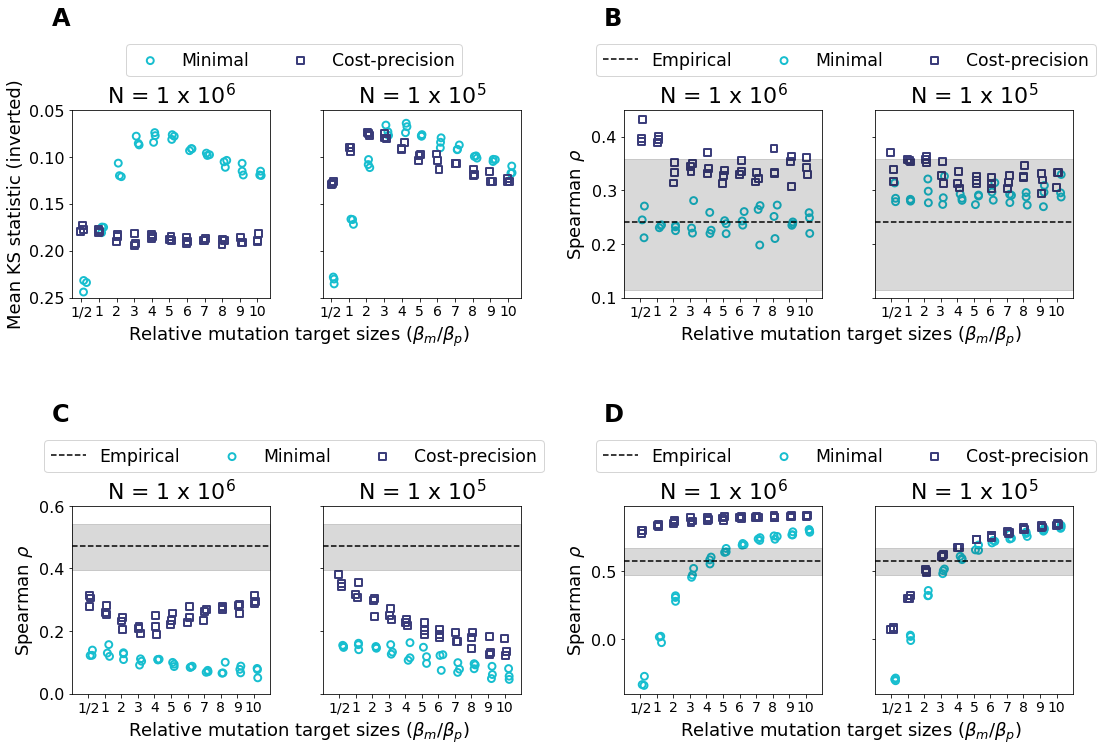

In [27]:
fig = plt.figure(constrained_layout=False, figsize=(17, 10))

# Preparation of the grids
gs1 = fig.add_gridspec(nrows=8, ncols=22, left=0.05, right=0.95, bottom=0.60, 
                       top=0.95, wspace=0.05)
ax1 = fig.add_subplot(gs1[1:7, 1:5])
ax2 = fig.add_subplot(gs1[1:7, 6:10])
ax3 = fig.add_subplot(gs1[1:7, 12:16])
ax4 = fig.add_subplot(gs1[1:7, 17:21])

gs2 = fig.add_gridspec(nrows=8, ncols=22, left=0.05, right=0.95, bottom=0.05, 
                       top=0.40, wspace=0.05)
ax5 = fig.add_subplot(gs2[1:7, 1:5])
ax6 = fig.add_subplot(gs2[1:7, 6:10])
ax7 = fig.add_subplot(gs2[1:7, 12:16])
ax8 = fig.add_subplot(gs2[1:7, 17:21])

# Parameters for the scatterplots
labels = ['1/2', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

size = 48

palette = {'Cost-precision': cm.tab20b.colors[0], 'Minimal': cm.tab10.colors[9]}
hue_order = ['Minimal', 'Cost-precision']
markers = {'Cost-precision': 's', 'Minimal':'o'}

facecolors = 'none'

linewidths = 1.95

# Min and Max for KS values
min_KS = 0.050
max_KS = 0.25

# First scatterplot
scatter1 = hue_scatter('num', 'KS stats', KS_WGD, 'Model', palette, hue_order,
                       markers, ax1, size=size, facecolors=facecolors,
                       linewidths=linewidths)

plt.sca(ax1) 
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ax1.set_xticklabels(['1/2', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
plt.ylim(bottom=min_KS, top=max_KS)
plt.tick_params(labelsize=16)

plt.gca().invert_yaxis() # Invert y-axis for KS stats

# Second scatterplot
scatter2 = hue_scatter('num', 'KS stats', KS_low_pop, 'Model', palette, 
                       hue_order, markers, ax2, size=size, facecolors=facecolors,
                       linewidths=linewidths)

plt.sca(ax2) 
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ax2.set_xticklabels(['1/2', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
plt.ylim(bottom=min_KS, top=max_KS)
plt.tick_params(labelsize=16)

plt.gca().invert_yaxis() # Invert y-axis for KS stats

# Min and max for the div correlation
min_div = 0.10
max_div = 0.45

# Third scatterplot
scatter3 = hue_scatter('num', 'spearman_div', corr_df, 'Model', palette, 
                       hue_order, markers, ax3, size=size, facecolors=facecolors,
                       linewidths=linewidths)
plt.sca(ax3) 
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ax3.set_xticklabels(['1/2', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
plt.ylim(bottom=min_div, top=max_div)
plt.tick_params(labelsize=16)

# Fourth scatterplot
scatter4 = hue_scatter('num', 'spearman_div', corr_pop, 'Model', palette, 
                       hue_order, markers, ax4, size=size, facecolors=facecolors,
                       linewidths=linewidths)
plt.sca(ax4) 
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ax4.set_xticklabels(['1/2', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
plt.ylim(bottom=min_div, top=max_div)
plt.tick_params(labelsize=16)

# Addition of the empirical correlation + 95% CI to scatters of correlation
for ax in [ax3, ax4]:
  ax.set_xlim(left=0, right=12)
  x_lims = ax.get_xlim()
  ax.axhline(y=center_div, c='k', linestyle='--', label='Empirical')
  ax.fill_between(x_lims, spearman_ci_div[0], spearman_ci_div[1], 
                  color='black', alpha=0.15)
  
# Min and max for the signed div correlation
min_sign = 0
max_sign = 0.60

# Fifth scatterplot
scatter5 = hue_scatter('num', 'spearman_sign', corr_df, 'Model', palette, 
                       hue_order, markers, ax5, size=size, 
                       facecolors=facecolors, linewidths=linewidths)

plt.sca(ax5) 
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ax5.set_xticklabels(['1/2', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
plt.ylim(bottom=min_sign, top=max_sign)
plt.tick_params(labelsize=16)

# Sixth scatterplot
scatter7 = hue_scatter('num', 'spearman_sign', corr_pop, 'Model', palette, 
                       hue_order, markers, ax6, size=size, 
                       facecolors=facecolors, linewidths=linewidths)

plt.sca(ax6) 
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ax6.set_xticklabels(['1/2', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
plt.ylim(bottom=min_sign, top=max_sign)
plt.tick_params(labelsize=16)

# Min and max for the div ratio correlation
min_ratio = -0.4
max_ratio = 0.98

# Seventh scatterplot
scatter7 = hue_scatter('num', 'spearman_ratio', corr_df, 'Model', palette, 
                       hue_order, markers, ax7, size=size, facecolors=facecolors,
                       linewidths=linewidths)
plt.sca(ax7) 
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ax7.set_xticklabels(['1/2', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
plt.ylim(bottom=min_ratio, top=max_ratio)
plt.tick_params(labelsize=16)

# Eighth scatterplot
scatter8 = hue_scatter('num', 'spearman_ratio', corr_pop, 'Model', palette, 
                       hue_order, markers, ax8, size=size, facecolors=facecolors,
                       linewidths=linewidths)
plt.sca(ax8) 
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ax8.set_xticklabels(['1/2', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
plt.ylim(bottom=min_ratio, top=max_ratio)
plt.tick_params(labelsize=16)

# Addition of the empirical correlation + 95% CI to scatters of correlation
for ax in [ax5, ax6]:
  ax.set_xlim(left=0, right=12)
  x_lims = ax.get_xlim()
  ax.axhline(y=center_sign, c='k', linestyle='--', label='Empirical')
  ax.fill_between(x_lims, spearman_ci_sign[0], spearman_ci_sign[1], 
                  color='black', alpha=0.15)
  
for ax in [ax7, ax8]:
  ax.set_xlim(left=0, right=12)
  x_lims = ax.get_xlim()
  ax.axhline(y=center_ratio, c='k', linestyle='--', label='Empirical')
  ax.fill_between(x_lims, spearman_ci_ratio[0], spearman_ci_ratio[1], 
                  color='black', alpha=0.15)

# Removing useless ytick labels
for ax in [ax2, ax4, ax6, ax8]:
  ax.set_ylabel('')
  ax.tick_params(labelleft=False)

# Legends and labels
ax1.legend(bbox_to_anchor=(1.12, 1.35), loc=9, borderaxespad=0,
                 fontsize='xx-large', ncol=2)

ax3.legend(bbox_to_anchor=(1.12, 1.35), loc=9, borderaxespad=0,
                 fontsize='xx-large', ncol=3)

ax5.legend(bbox_to_anchor=(1.12, 1.35), loc=9, borderaxespad=0,
                 fontsize='xx-large', ncol=3)

ax7.legend(bbox_to_anchor=(1.12, 1.35), loc=9, borderaxespad=0,
                 fontsize='xx-large', ncol=3)

ax1.set_ylabel(r"Mean KS statistic (inverted)", fontsize=18)
ax3.set_ylabel(r"Spearman $\rho$", fontsize=18)
ax5.set_ylabel(r"Spearman $\rho$", fontsize=18)
ax7.set_ylabel(r"Spearman $\rho$", fontsize=18)

# Manual addition of xlabels
ax1.annotate(r"Relative mutation target sizes ($\beta_m$/$\beta_p$)",
             (0.285, -0.225), xycoords='axes fraction', fontsize=18)
ax3.annotate(r"Relative mutation target sizes ($\beta_m$/$\beta_p$)",
             (0.285, -0.225), xycoords='axes fraction', fontsize=18)
ax5.annotate(r"Relative mutation target sizes ($\beta_m$/$\beta_p$)",
             (0.285, -0.225), xycoords='axes fraction', fontsize=18)
ax7.annotate(r"Relative mutation target sizes ($\beta_m$/$\beta_p$)",
             (0.285, -0.225), xycoords='axes fraction', fontsize=18)

# Manual setting of xtick labels size
for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]:
  ax.tick_params(axis='x', which='major', labelsize=14)

ax1.set_title(r"N = 1 x $10^6$", fontsize=22)
ax2.set_title(r"N = 1 x $10^5$", fontsize=22)
ax3.set_title(r"N = 1 x $10^6$", fontsize=22)
ax4.set_title(r"N = 1 x $10^5$", fontsize=22)
ax5.set_title(r"N = 1 x $10^6$", fontsize=22)
ax6.set_title(r"N = 1 x $10^5$", fontsize=22)
ax7.set_title(r"N = 1 x $10^6$", fontsize=22)
ax8.set_title(r"N = 1 x $10^5$", fontsize=22)

ax1.annotate('A', (-0.1, 1.45), xycoords='axes fraction', fontsize=24, 
             fontweight='bold')
ax3.annotate('B', (-0.1, 1.45), xycoords='axes fraction', fontsize=24, 
             fontweight='bold')
ax5.annotate('C', (-0.1, 1.45), xycoords='axes fraction', fontsize=24, 
             fontweight='bold')
ax7.annotate('D', (-0.1, 1.45), xycoords='axes fraction', fontsize=24, 
             fontweight='bold')

# Saving the figure
Fig4 = plt.gcf()
Fig4.savefig('/content/drive/My Drive/Redaction_SA/Final_figures/'
             'Fig4_final.pdf', bbox_inches='tight')